In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

**Before we implement SVM, let's see the math behind it.**

We have our equation of the line in 2D, plane in 3D and hypterplane in ND.

$$
    y(X) = \sum_{x_{i}fromX}{x_{i}w_{i}} + b
$$
    or
$$
    y(X) = w^{T}x
$$

Consider the case of binar classification. t's are target values, -1 or 1.
We want the predicted value to be of the same sign as the target.

$$
    t_{n}y(x_{n}) > 0
$$

distance from the line to the point.

$$
    \frac{t_{n}y(x_{n})}{||w||} = \frac{t_{n}(w^{T}x_{n} + b)}{||w||}
$$

and we want that the minimum distance from the closest point x_n be maxmimum.

$$
    argmin_{w, b}[ \frac{1}{||w||} min_{n} [t_{n}y(x_{n})] ]
$$

this problem has a very complex solution. Note that if we set w -> kw and b -> kb we are able to find w and b such that the distance from the closest point x_n from the surface is 1.

$$
    t_{n}(w^{T}x_{n}) + b = 1
$$

moreover

$$
    \frac{1}{||w||} = ||w||^{-1} = \frac{1}{2}||w||^{2}
$$

we are left with.

$$
    argmin_{w, b} [\frac{1}{2}||w||^{2}]
$$

and we solve it using Lagrange multipliers.

*Referance: Bishop - Pattern Recognition and Machine Learning p. 328*

**The implementation using the above principles can be found here.** https://xavierbourretsicotte.github.io/SVM_implementation.html

I am going to use gradient decent to train SVM.

The hinge loss.

$$
    L(w)=max[0, 1 - t_{n}y(x_{n})]
$$

<img src="hinge_der.png" width=400 />

In [3]:
class ImpBinarSVC:

    def __init__(self, C=0.1):
        self.coef_ = np.empty(0)
        self.C = C
        self.lr = 0.01
        self.lmb = 0
        self.n_iters = 10

    def __init_svm(self, feature_size, C=None, learning_rate=None, n_iters=None, lmb=None):
                                      # weights + bias
        self.coef_ = np.random.normal(0, 1, feature_size+1)
        if C: self.C = C
        if learning_rate: self.lr = learning_rate
        if n_iters: self.n_iters = n_iters
        if lmb: self.lmb = lmb
    
    def hinge_loss(self, y_target, y_pred):
        # TODO
        return np.array([np.max(0, 1 - t * p) for t, p in zip(y_target, y_pred)])
    
    def fit(self, X, y, C=None, learning_rate=0.001, n_iters=1000, lmb=0.01):
        # TODO
        y[np.where(y == 0)[0]] = -1
        # y[np.where(y == 1)[0]] = 1
        
        self.__init_svm(X.shape[1], C, learning_rate, n_iters, lmb)

        for i in range(n_iters):
            y_pred = self.predict(X)
            y_pred[y_pred == 0] = -1

            for x, y_t, y_p in zip(X, y, y_pred):
                if y_t * y_p >= (1 - self.C):
                    self.coef_[1:] -= 2 * self.lmb * np.sign(self.coef_[1:])
                else:
                    self.coef_[1:] -= self.lr * - y_t * x + 2 * self.lmb * np.sign(self.coef_[1:])
                    self.coef_[0] -= self.lr * y_t

    def _pred(self, X):
        X = np.c_[np.ones(len(X)), X]
        return np.dot(X, self.coef_)

    def predict(self, X):
        # TODO
        pred = np.sign(self._pred(X))
        pred[pred == -1] = 0
        return pred

    @property
    def coef(self):
        return self.coef_[1:]

    @property
    def intercept(self):
        return self.coef_[0]

In [4]:
X, y =  datasets.make_blobs(n_samples=150, n_features=2, centers=2, cluster_std=1.05, random_state=40)

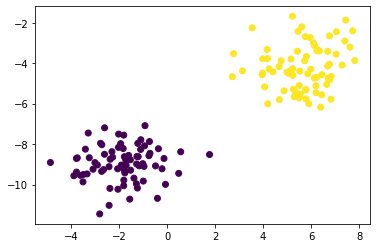

In [5]:
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3)

In [7]:
svm = ImpBinarSVC()
svm.fit(X_train, y_train, n_iters=1000, learning_rate=0.8, lmb=0.1)

In [8]:
accuracy_score(y_test, svm.predict(X_test))

1.0

In [9]:
# one-vs-rest 
class ImpSVC:
    
    def __init__(self):
        self.__init_clf()
        
    def __init_clf(self):
        self.binar_clfs = []
        
    def fit(self, X, y, **kwargs):
        self.__init_clf()
        
        unique_y, count = np.unique(y, return_counts=True)
        
        for y_u in unique_y:
            mask = (y == y_u)
            y_target = y.copy()
            y_target[mask] = 1
            y_target[~mask] = 0
            clf = ImpBinarSVC()
            
            clf.fit(X, y_target, **kwargs)
            self.binar_clfs.append(clf)
            
    def predict(self, X):
        return np.argmax([np.abs(clf._pred(X)) for clf in self.binar_clfs], axis=0)

[-0.01893767  0.01537858] -76.24933258208563


/var/folders/2v/0tr3wk2s1tn4fntw0fbqt3fh0000gn/T/ipykernel_47387/2875360648.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


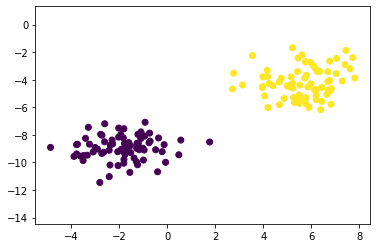

In [10]:
clf = ImpBinarSVC()
clf.fit(X, y)
#predictions = clf.predict(X)
 
print(clf.coef, clf.intercept)

def visualize_svm():
    def get_hyperplane_value(x, w, b, offset):
        return (-w[0] * x + b + offset) / w[1]

    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.scatter(X[:,0], X[:,1], marker='o',c=y)

    x0_1 = np.amin(X[:,0])
    x0_2 = np.amax(X[:,0])

    x1_1 = get_hyperplane_value(x0_1, clf.coef, clf.intercept, 0)
    x1_2 = get_hyperplane_value(x0_2, clf.coef, clf.intercept, 0)

    x1_1_m = get_hyperplane_value(x0_1, clf.coef, clf.intercept, -1)
    x1_2_m = get_hyperplane_value(x0_2, clf.coef, clf.intercept, -1)

    x1_1_p = get_hyperplane_value(x0_1, clf.coef, clf.intercept, 1)
    x1_2_p = get_hyperplane_value(x0_2, clf.coef, clf.intercept, 1)

    ax.plot([x0_1, x0_2],[x1_1, x1_2], 'y--')
    ax.plot([x0_1, x0_2],[x1_1_m, x1_2_m], 'k')
    ax.plot([x0_1, x0_2],[x1_1_p, x1_2_p], 'k')

    x1_min = np.amin(X[:,1])
    x1_max = np.amax(X[:,1])
    ax.set_ylim([x1_min-3,x1_max+3])

    fig.show()

visualize_svm()

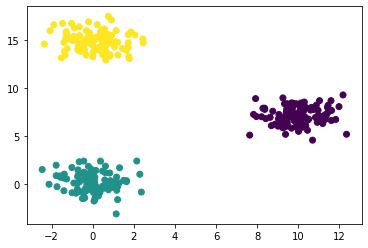

In [11]:
X1 = np.vstack((np.random.normal(10, 1, (100)), np.random.normal(7, 1, (100)))).T
X2 = np.vstack((np.random.normal(0, 1, (100)), np.random.normal(0, 1, (100)))).T
X3 = np.vstack((np.random.normal(0, 1, (100)), np.random.normal(15, 1, (100)))).T

X = np.vstack((X1, X2, X3))
y = np.vstack((np.zeros(100), np.ones(100), 2*np.ones(100))).flatten()

plt.scatter(X[:, 0], X[:, 1], c=y)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=2021)

In [13]:
svm = ImpSVC()
svm.fit(X_train, y_train, C=0.0, n_iters=2000, learning_rate=0.5, lmb=0.1)

In [14]:
accuracy_score(y_test, svm.predict(X_test))

0.13333333333333333

As we can see multiclass SVM does not work well. I tried to visualize the problem.

First SVM.
<img src="multi_prob/c3.png" width=300/>

Second SVM.
<img src="multi_prob/c2.png" width=300/>

Third SVM.
<img src="multi_prob/c1.png" width=300/>